# Paper Figures

This notebook generates the figures for the paper (and some bonus figures for checking that everything works as expected).

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
colors = sns.color_palette(palette="magma", n_colors=8)

import numpy as np
import scipy.stats
import scipy.special
import scipy.fftpack
from tqdm import tqdm
from astropy.modeling import models

from stingray import Lightcurve, Crossspectrum, Powerspectrum
from stingray import AveragedPowerspectrum, AveragedCrossspectrum
from stingray.simulator.simulator import Simulator

# add code directory so I can import functions
import sys
sys.path.append("../code/")

# add data directory and figure directory for reading data 
# and saving figures, respectively
datadir = "../data/"
figdir = "../paper/figs/"

# the indices of the frequencies to store
# We will not store full periodograms etc for 
# space reasons
# need to be the same indices as in the GenerateData.ipynb notebook!
idx_all = [10, 100, 1000]

/Users/danielahuppenkothen/work/sw/miniconda3/envs/stingraydev/lib/python3.9/site-packages/stingray-0.4.dev40+g3088cf1-py3.9.egg/stingray/largememory.py:25: UserWarning: Large Datasets may not be processed efficiently due to computational constraints
  warnings.warn(
/Users/danielahuppenkothen/work/sw/miniconda3/envs/stingraydev/lib/python3.9/site-packages/stingray-0.4.dev40+g3088cf1-py3.9.egg/stingray/crossspectrum.py:28: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/danielahuppenkothen/work/sw/miniconda3/envs/stingraydev/lib/python3.9/site-packages/stingray-0.4.dev40+g3088cf1-py3.9.egg/stingray/crosscorrelation.py:8: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/danielahuppenkothen/work/sw/miniconda3/envs/stingraydev/lib/python3.9/site-packages/stingray-0.4.dev40+g3088cf1-py3.9.egg/stingray/bispectrum.py:10: User

## Sample Light Curve, Periodogram and Cospectrum

Let's plot a sample light curve, periodogram and cospectrum

In [2]:
lc_data = np.loadtxt(datadir + "test_lc.dat")
lc = Lightcurve(lc_data[:,0], lc_data[:,1], skip_checks=True)

psd_data = np.loadtxt(datadir + "test_psd.dat")
freq = psd_data[:,0]
power_rn = psd_data[:,1]
power1 = psd_data[:,2]
power2 = psd_data[:,3]
cpower = psd_data[:,4]

avg_psd_data = np.loadtxt(datadir + "avg_per.dat")
avg_freq = avg_psd_data[:,0]
avg_cpower = avg_psd_data[:,-1]

I also want the underlying powerspectrum:

In [3]:
params = np.loadtxt(datadir + "opt_pars.dat")

In [4]:
params = params[0]

In [5]:
params

array([3.20245689e+05, 1.98782331e+00, 1.99663889e+00])

In [6]:
mrn = models.PowerLaw1D() 
mrn.x_0.fixed=True

mrn.amplitude = params[0]
mrn.alpha= params[1]
#mrn.amplitude_1 = params[2]

mps_rn = mrn(freq)

<IPython.core.display.Javascript object>


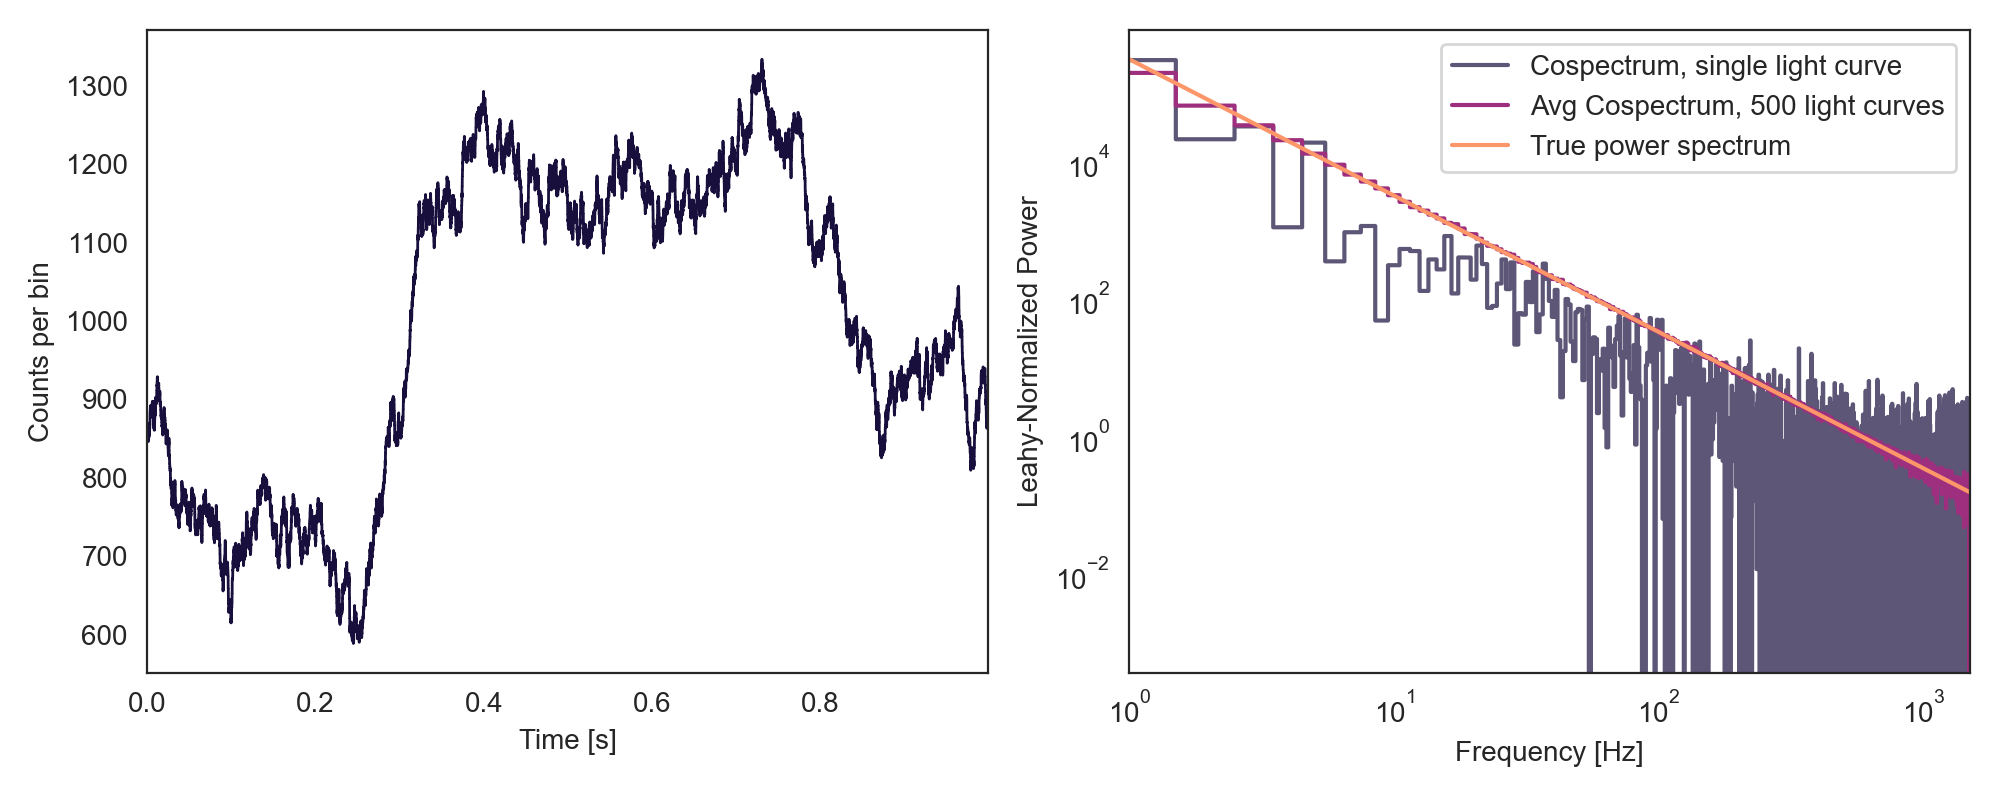

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.counts, ds="steps-mid", color=colors[0], lw=1)
ax1.set_xlim(lc.time[0], lc.time[-1])

ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Counts per bin")

ax2.loglog(freq[:1500], cpower[:1500], ds="steps-mid",
           label="Cospectrum, single light curve", color=colors[0], alpha=0.7)
ax2.loglog(freq[:1500], avg_cpower[:1500], ds="steps-mid",
           label="Avg Cospectrum, 500 light curves", color=colors[3], alpha=1.0)

ax2.loglog(freq[:1500], mps_rn[:1500], color=colors[6], 
           label="True power spectrum")
ax2.set_xlim(freq[0], freq[1500])

ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-Normalized Power")

ax2.legend()
plt.tight_layout()

plt.savefig(figdir + "example_lc.pdf", format="pdf")

## Fourier Amplitude Distributions

Let's plot the distributions of Fourier amplitudes, based on the data we've saved:

In [8]:
fdata = np.loadtxt(datadir + "fourier_small.dat", dtype=complex, 
                   converters={0: lambda s: complex(s.decode().replace('+-', '-'))})

f1_all = fdata[:,:3]
f2_all = fdata[:,3:6]
fdiff_all = fdata[:,6:]

We also need some additional information:

In [9]:
lccounts_data = np.loadtxt(datadir + "lc_counts_all.dat").T

lc1_counts_all = lccounts_data[0]
lc2_counts_all = lccounts_data[1]

meancounts1 = np.mean(lc1_counts_all)
meancounts2 = np.mean(lc2_counts_all)

Now we can plot the distributions for the three different frequencies, with the theoretically expected normal distribution as well:

In [10]:
params = np.loadtxt(datadir + "opt_pars.dat")

In [11]:
params

array([[ 3.20245689e+05,  1.98782331e+00,  1.99663889e+00],
       [ 3.33490711e+05,  1.99656603e+00, -1.04114680e-04]])

In [12]:
p = params[0]
mrn = models.PowerLaw1D() + models.Const1D()
mrn.x_0_0.fixed=True

mrn.amplitude_0 = p[0]
mrn.alpha_0= p[1]
mrn.amplitude_1 = p[2]

mps = mrn(freq)

<IPython.core.display.Javascript object>


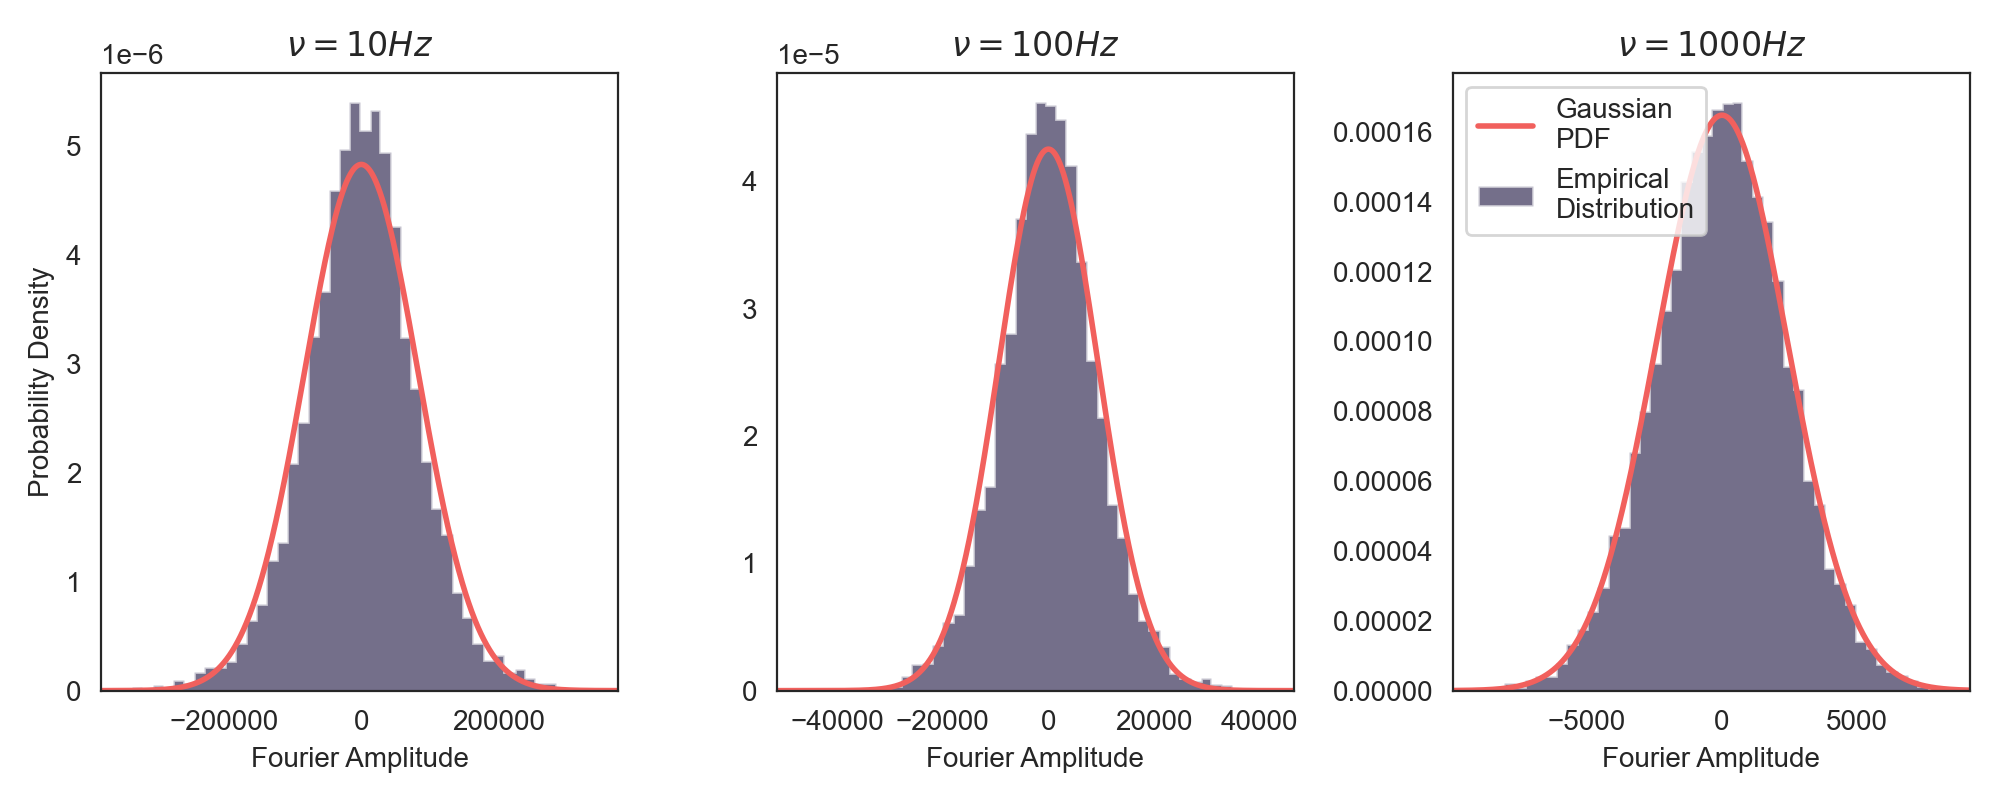

[10, 100, 1000]
52.22138246497165
[10, 100, 1000]
5.933374415519368
[10, 100, 1000]
1.5311092429589188


In [13]:
fig, axes = plt.subplots(1, 3, figsize=(10,4))

nbins = 50
histcolor = colors[0]
distcolor = colors[5]

#adjust = [-8000, -80, 0.0 ]
adjust = [0,0,0]
for i,idx in enumerate(idx_all):
    print(idx_all)
    
    f1 = f1_all[:,i].real

    norm = scipy.stats.norm(0, np.sqrt((mps[idx] + adjust[i])/4.0*meancounts1))
    print(np.sqrt(mps[idx]))
    min_val = np.min(f1)
    max_val = np.max(f1)
    u = np.linspace(min_val, max_val, 100000)
    prob_norm = norm.pdf(u)
    
    axes[i].hist(f1, bins=nbins, histtype="stepfilled", 
                 color=histcolor, alpha=0.6, density=True, label="Empirical\nDistribution")
    axes[i].plot(u, prob_norm, lw=2, color=distcolor, label="Gaussian\nPDF")
    axes[i].set_xlim(min_val, max_val)
    axes[i].set_xlabel("Fourier Amplitude")
    axes[i].set_title(r"$\nu = %i Hz$"%(freq[idx-1]))

axes[0].set_ylabel("Probability Density")
axes[-1].legend()
plt.tight_layout()
plt.savefig(figdir + "fourier_amp.pdf", format="pdf")

## Covariances and Variances

I want a plot of the variances, covariances and the correlation coefficient:

In [14]:
cov_all = np.loadtxt(datadir + "cov_all.dat")
cov_all = cov_all.reshape((1500, 2, 2))

In [15]:
corr_coeff_data = np.loadtxt(datadir + "corrcoeff.dat")
corr_coeff_real = corr_coeff_data[1,:]
corr_coeff_imag = corr_coeff_data[2,:]

In [16]:
corr_coeff_real

array([0.99999005, 0.99997098, 0.99994047, ..., 0.07288984, 0.0923033 ,
       0.06271437])

We also need to calculate the theoretical expectation for the correlation coefficient:

In [17]:
def calculate_r(mpower):
    return (mpower / (mpower + 2))

In [18]:
rtest = calculate_r(mps_rn)

<IPython.core.display.Javascript object>


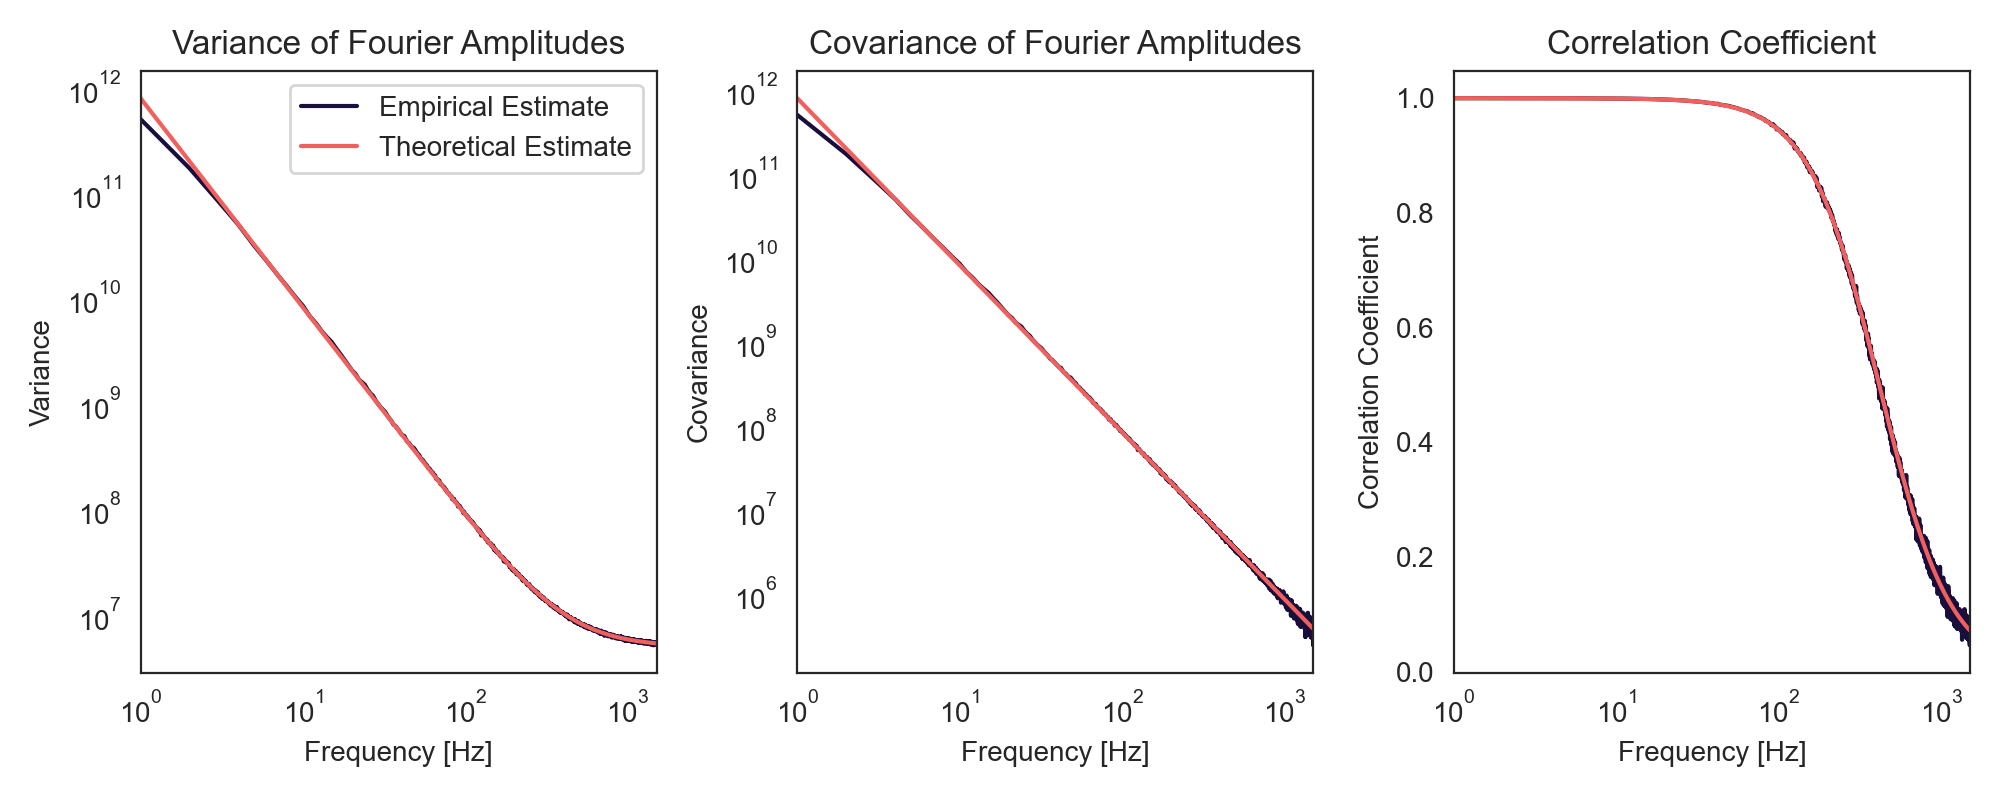

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))

ax1.loglog(freq[:1500], cov_all[:,0,0], 
           color=histcolor, label="Empirical Estimate")
ax1.loglog(freq[:1500], mps[:1500]*meancounts1/4.0, 
           color=distcolor, label="Theoretical Estimate")

ax1.set_xlim(freq[0], freq[1500])
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Variance")
ax1.set_title("Variance of Fourier Amplitudes")
ax1.legend()

ax2.loglog(freq[:1500], cov_all[:,0,1], 
           color=histcolor, label="Empirical Covariance")
ax2.loglog(freq[:1500], mps_rn[:1500]*meancounts1/4.0, 
           color=distcolor, label="Theoretical Estimate")
ax2.set_xlim(freq[0], freq[1500])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Covariance")
ax2.set_title("Covariance of Fourier Amplitudes")
#ax2.legend()

ax3.semilogx(freq[:1500], corr_coeff_real[:1500], color=histcolor, label="Empirical \nCorrelation Coefficient")
ax3.plot(freq[:1500], rtest[:1500], color=distcolor, label="Theoretical Estimate")
ax3.set_xlim(freq[0], freq[1500])
ax3.set_xlabel("Frequency [Hz]")
ax3.set_ylabel("Correlation Coefficient")
ax3.set_title("Correlation Coefficient")
#ax3.legend()

plt.tight_layout()
plt.savefig(figdir + "covar_correl.pdf")

## Squared Fourier Amplitude

Same plot, but squared Fourier amplitudes, with the (simplified) variance-gamma distribution. For this probability, we need the standard deviations at each frequency, and the correlation coefficient (which we imported above).

In [20]:
std1 = np.sqrt(cov_all[:,0,0])
std2 = np.sqrt(cov_all[:,1,1])

In [21]:
model_var = (mps_rn[:1500]+2)*meancounts1/4
model_std = np.sqrt(model_var)

In [22]:
from fourierprob import bessel_probability_corr

In [23]:
fsq_data = np.loadtxt(datadir + "fsquared_all.dat",  dtype=complex, 
                   converters={0: lambda s: complex(s.decode().replace('+-', '-'))})

In [24]:
fourier_squared_test = fsq_data[:,:3]

In [25]:
idx = idx_all[0]

In [26]:
model_std[idx]

82569.5353042403

In [27]:
i = 0

In [28]:
def fourier_product_probability(x, std1, std2, corr):
    corr_fac = (1 - corr**2.)
    pre_term = 1 / (np.pi * std1 * std2 * np.sqrt(corr_fac))
    exp_term = np.exp((corr * x) / (std1 * std2 * corr_fac))
    bessel_fac = np.abs(x) / (std1 * std2 * corr_fac)
    bessel_term = scipy.special.kv(0, bessel_fac)
    
    return pre_term * exp_term * bessel_term

In [29]:
fsq = fourier_squared_test[:,i]
min_val = np.min(fsq.real)
max_val = np.max(fsq.real)

u = np.linspace(min_val, max_val, 10000)
bprob = fourier_product_probability(u, model_std[idx], model_std[idx], corr_coeff_real[idx])




<ipython-input-28-cf9dca338430>:4: RuntimeWarning: overflow encountered in exp
  exp_term = np.exp((corr * x) / (std1 * std2 * corr_fac))
<ipython-input-28-cf9dca338430>:8: RuntimeWarning: invalid value encountered in multiply
  return pre_term * exp_term * bessel_term


In [30]:
u

array([-3.47197778e+07, -2.04665494e+07, -6.21332101e+06, ...,
        1.42454804e+11,  1.42469058e+11,  1.42483311e+11])

In [31]:
max_val

142483310801.79147

In [32]:
bprob

array([7.32858906e-13, 1.65046922e-11, 4.87859121e-10, ...,
                  nan,            nan,            nan])

<IPython.core.display.Javascript object>


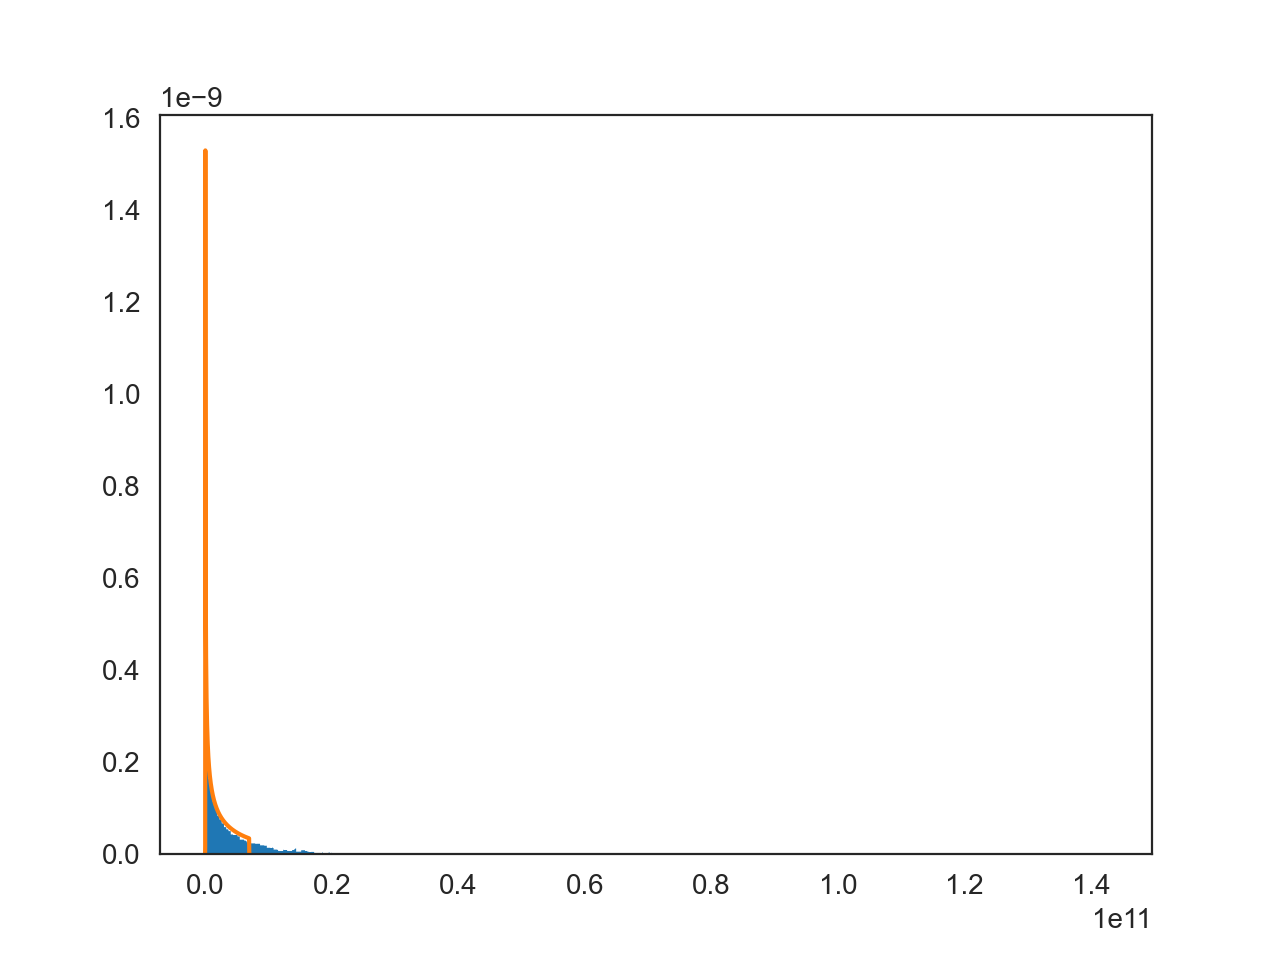

In [33]:
plt.figure()
plt.hist(fourier_squared_test[:,0].real, bins=400, histtype="stepfilled", density=True)
plt.plot(u, bprob)

In [157]:
model_std[idx_all[0]]

269944.2305854743

In [158]:
corr_coeff_real[idx_all[0]]

0.9999312055792612

In [ ]:
min_val

In [ ]:
bessel_probability_corr(model_std[idx_all[0]])

<IPython.core.display.Javascript object>


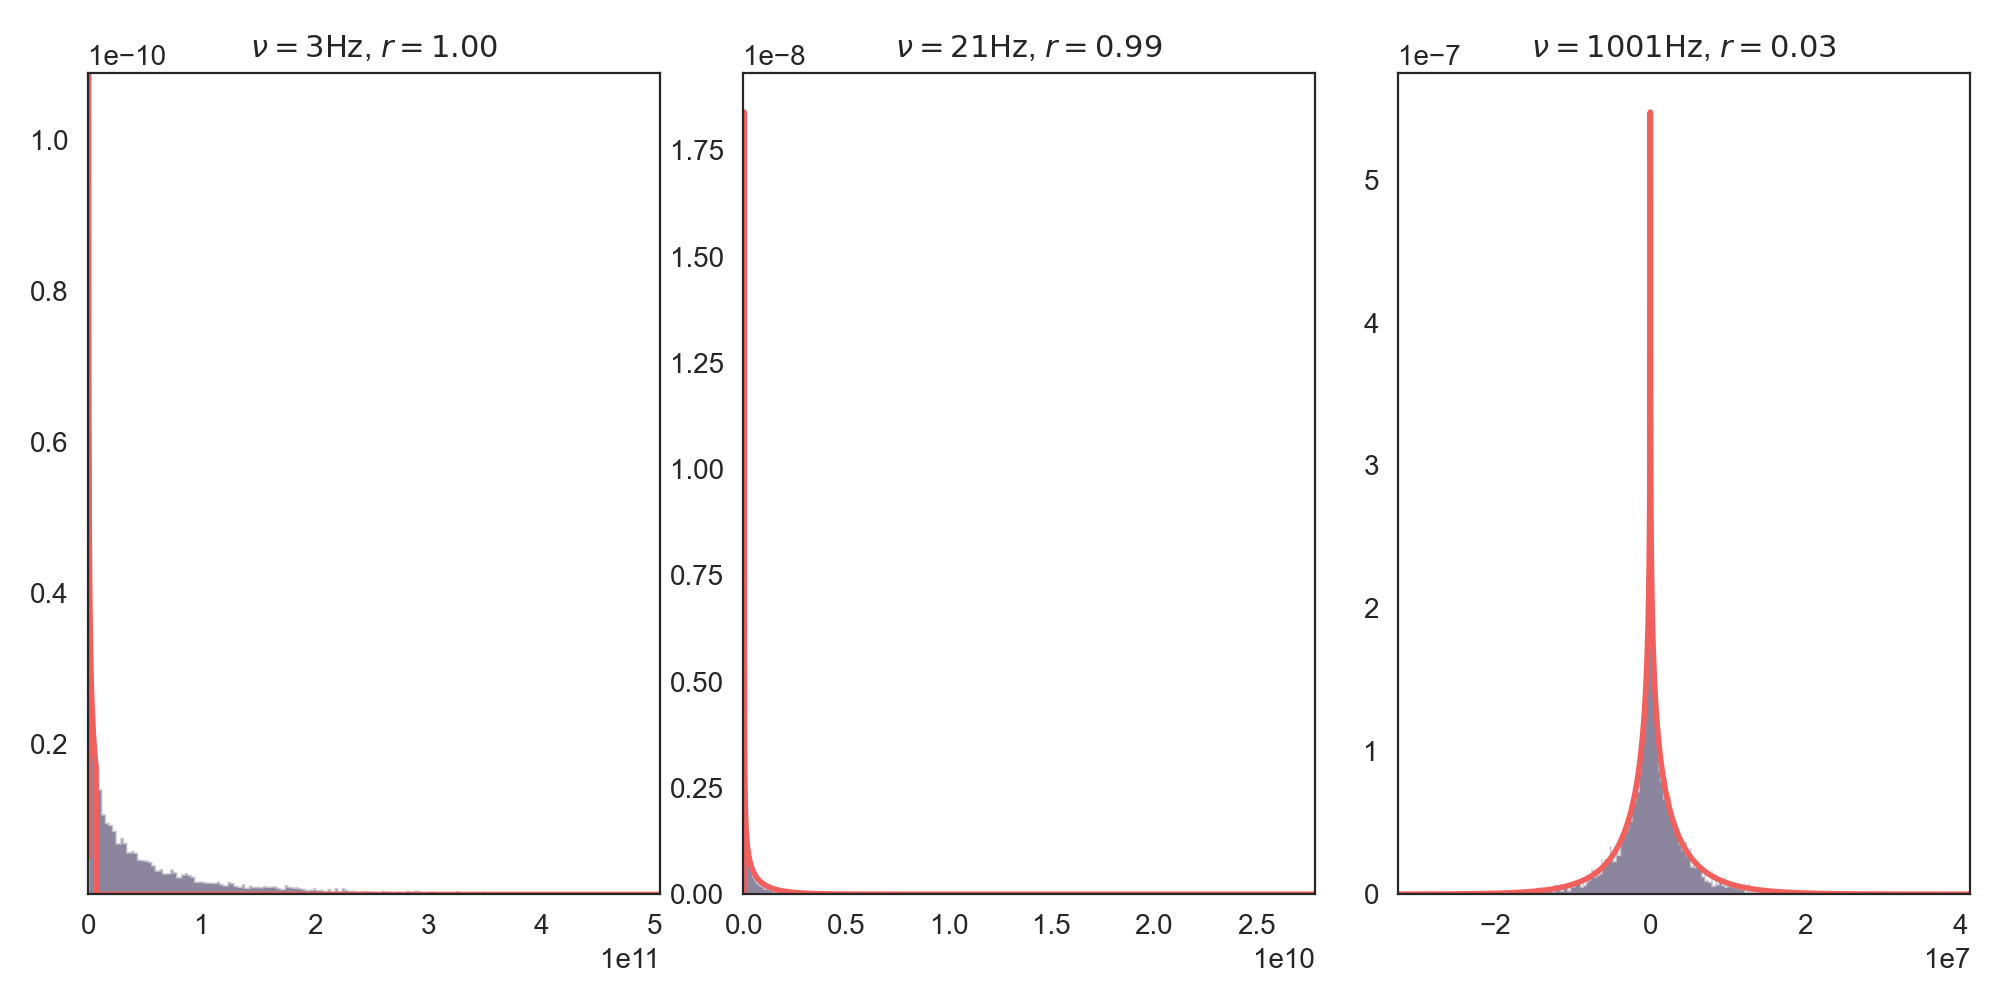

/Users/danielahuppenkothen/work/repositories/dragons-project/notebooks/../code/fourierprob.py:58: RuntimeWarning: divide by zero encountered in log
  logy = np.log(z_abs) - np.log(std1) - np.log(std2) - np.log(corr_fac)
/Users/danielahuppenkothen/work/sw/miniconda3/envs/stingraydev/lib/python3.9/site-packages/numpy/lib/histograms.py:851: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/danielahuppenkothen/work/sw/miniconda3/envs/stingraydev/lib/python3.9/site-packages/numpy/lib/histograms.py:904: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/Users/danielahuppenkothen/work/sw/miniconda3/envs/stingraydev/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6837: ComplexWarning: Casting complex values to real discards the imaginary part
  x[0:2*len(bins)-1:2], x[1:2*len(bins)-1:2] = bins, bins[:-1]
/Users/danielahuppenkothen/work/sw/miniconda3/env

In [155]:
fig, axes = plt.subplots(1, 3, figsize=(10,5))

for i, idx in enumerate(idx_all):
    fsq = fourier_squared_test[:,i]
    min_val = np.min(fsq)
    max_val = np.max(fsq)
    
    u = np.linspace(min_val, max_val, 10000)
    bprob = bessel_probability_corr(u, model_std[idx], model_std[idx], corr_coeff_real[idx])
    
    axes[i].hist(fsq.real, bins=400, range=[min_val, max_val], alpha=0.5, 
         color=histcolor, density=True, histtype="stepfilled")

    axes[i].plot(u, bprob, lw=2, color=distcolor)
    axes[i].set_xlim(min_val, max_val)
    axes[i].set_title(r"$\nu = %i \mathrm{Hz}$, $r = %.2f$"%(freq[idx],corr_coeff_real[idx]), fontsize=11)


#ax1.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))


#ax2.set_xlabel(r"$A_{xj}A_{yj}$")
#ax1.set_ylabel("Probability density")

#ax3.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
#ax3.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))


plt.tight_layout(w_pad=0.35)
#plt.savefig("rednoise_bessel.pdf", format="pdf")